In [8]:
# Test Data
import numpy
from ipywidgets import widgets

image_path = 'paintings/0.png'
sample_image_height_mm = 970

baguette_path = 'baguettes/BR 510-A39103-49.jpg'
sample_baguette_height_mm = 93

In [9]:
from PIL import Image, ImageDraw

painting_sample = Image.open(image_path, 'r')

In [10]:
baguette_sample = Image.open(baguette_path, 'r')

In [11]:
def add_baguette(painting, baguette, image_height_mm, baguette_height_mm):

    baguette_real_scale = image_height_mm / baguette_height_mm
    baguette_image_scale = painting.height / baguette.height

    baguette_scale = baguette_image_scale / baguette_real_scale
    baguette_scaled = baguette.resize((int(baguette.width * baguette_scale), int(baguette.height * baguette_scale)))

    baguette_n = baguette_scaled
    baguette_w = baguette_scaled.rotate(90, expand=1)
    baguette_s = baguette_scaled.rotate(180, expand=1)
    baguette_e = baguette_scaled.rotate(270, expand=1)

    result_width = baguette_w.width + painting.width + baguette_e.width
    result_height = baguette_n.height + painting.height + baguette_s.height

    result = Image.new('RGB', (result_width, result_height))

    for i in range(int(result_width / baguette_n.width) + 1):
        result.paste(baguette_n, (i * baguette_n.width, 0))

    for i in range(int(result_height / baguette_w.height) + 1):
        result.paste(baguette_w, (0, i * baguette_w.height))

    for i in range(int(result_width / baguette_s.width) + 1):
        result.paste(baguette_s, (i * baguette_s.width, result_height - baguette_s.height))

    for i in range(int(result_height / baguette_e.height) + 1):
        result.paste(baguette_e, (result_width - baguette_e.width, i * baguette_e.height))

    result.paste(painting, (baguette_e.width, baguette_n.height))

    def nw(image):
        return [(0,0), (image.width, 0) ,(image.width, image.height)]

    def sw(image):
        return [(0, image.height), (image.width, 0) ,(image.width, image.height)]

    def se(image):
        return [(0,0), (0, image.height) ,(image.width, image.height)]

    def ne(image):
        return [(0,0), (0, image.height), (image.height, 0)]

    # Fill corners properly
    def triangle_cut(image, pos='nw'):
        # Make square image
        min_side = min(image.height, image.width)
        image = image.copy().crop((0, 0, min_side, min_side))

        image_array = numpy.asarray(image.convert('RGBA'))

        if pos == 'nw':
            polygon = nw(image)
        if pos == 'sw':
            polygon = sw(image)
        if pos == 'se':
            polygon = se(image)
        if pos == 'ne':
            polygon = ne(image)

        maskIm = Image.new('L', (image_array.shape[1], image_array.shape[0]), 0)
        ImageDraw.Draw(maskIm).polygon(polygon, outline=1, fill=1)
        mask = numpy.array(maskIm)

        # assemble new image (uint8: 0-255)
        newImArray = numpy.empty(image_array.shape, dtype='uint8')

        # colors (three first columns, RGB)
        newImArray[:,:,:3] = image_array[:,:,:3]

        # transparency (4th column)
        newImArray[:,:,3] = mask * 255

        # back to Image from numpy
        return Image.fromarray(newImArray, 'RGBA')

    def fill_corner(baguette, corner, coordinates):
        baguette_corner = triangle_cut(baguette, corner)
        result.paste(baguette_corner, coordinates, baguette_corner)

    fill_corner(baguette_n.copy(), 'nw', (0, 0))
    fill_corner(baguette_w.copy(), 'ne', (0, result.height - min(baguette_w.height, baguette_w.width)))
    fill_corner(baguette_s.copy(), 'se', (result.width - min(baguette_s.height, baguette_s.width), result.height - min(baguette_s.height, baguette_s.width)))
    fill_corner(baguette_n.copy(), 'ne', (result.width - min(baguette_n.height, baguette_n.width), 0))

    return result

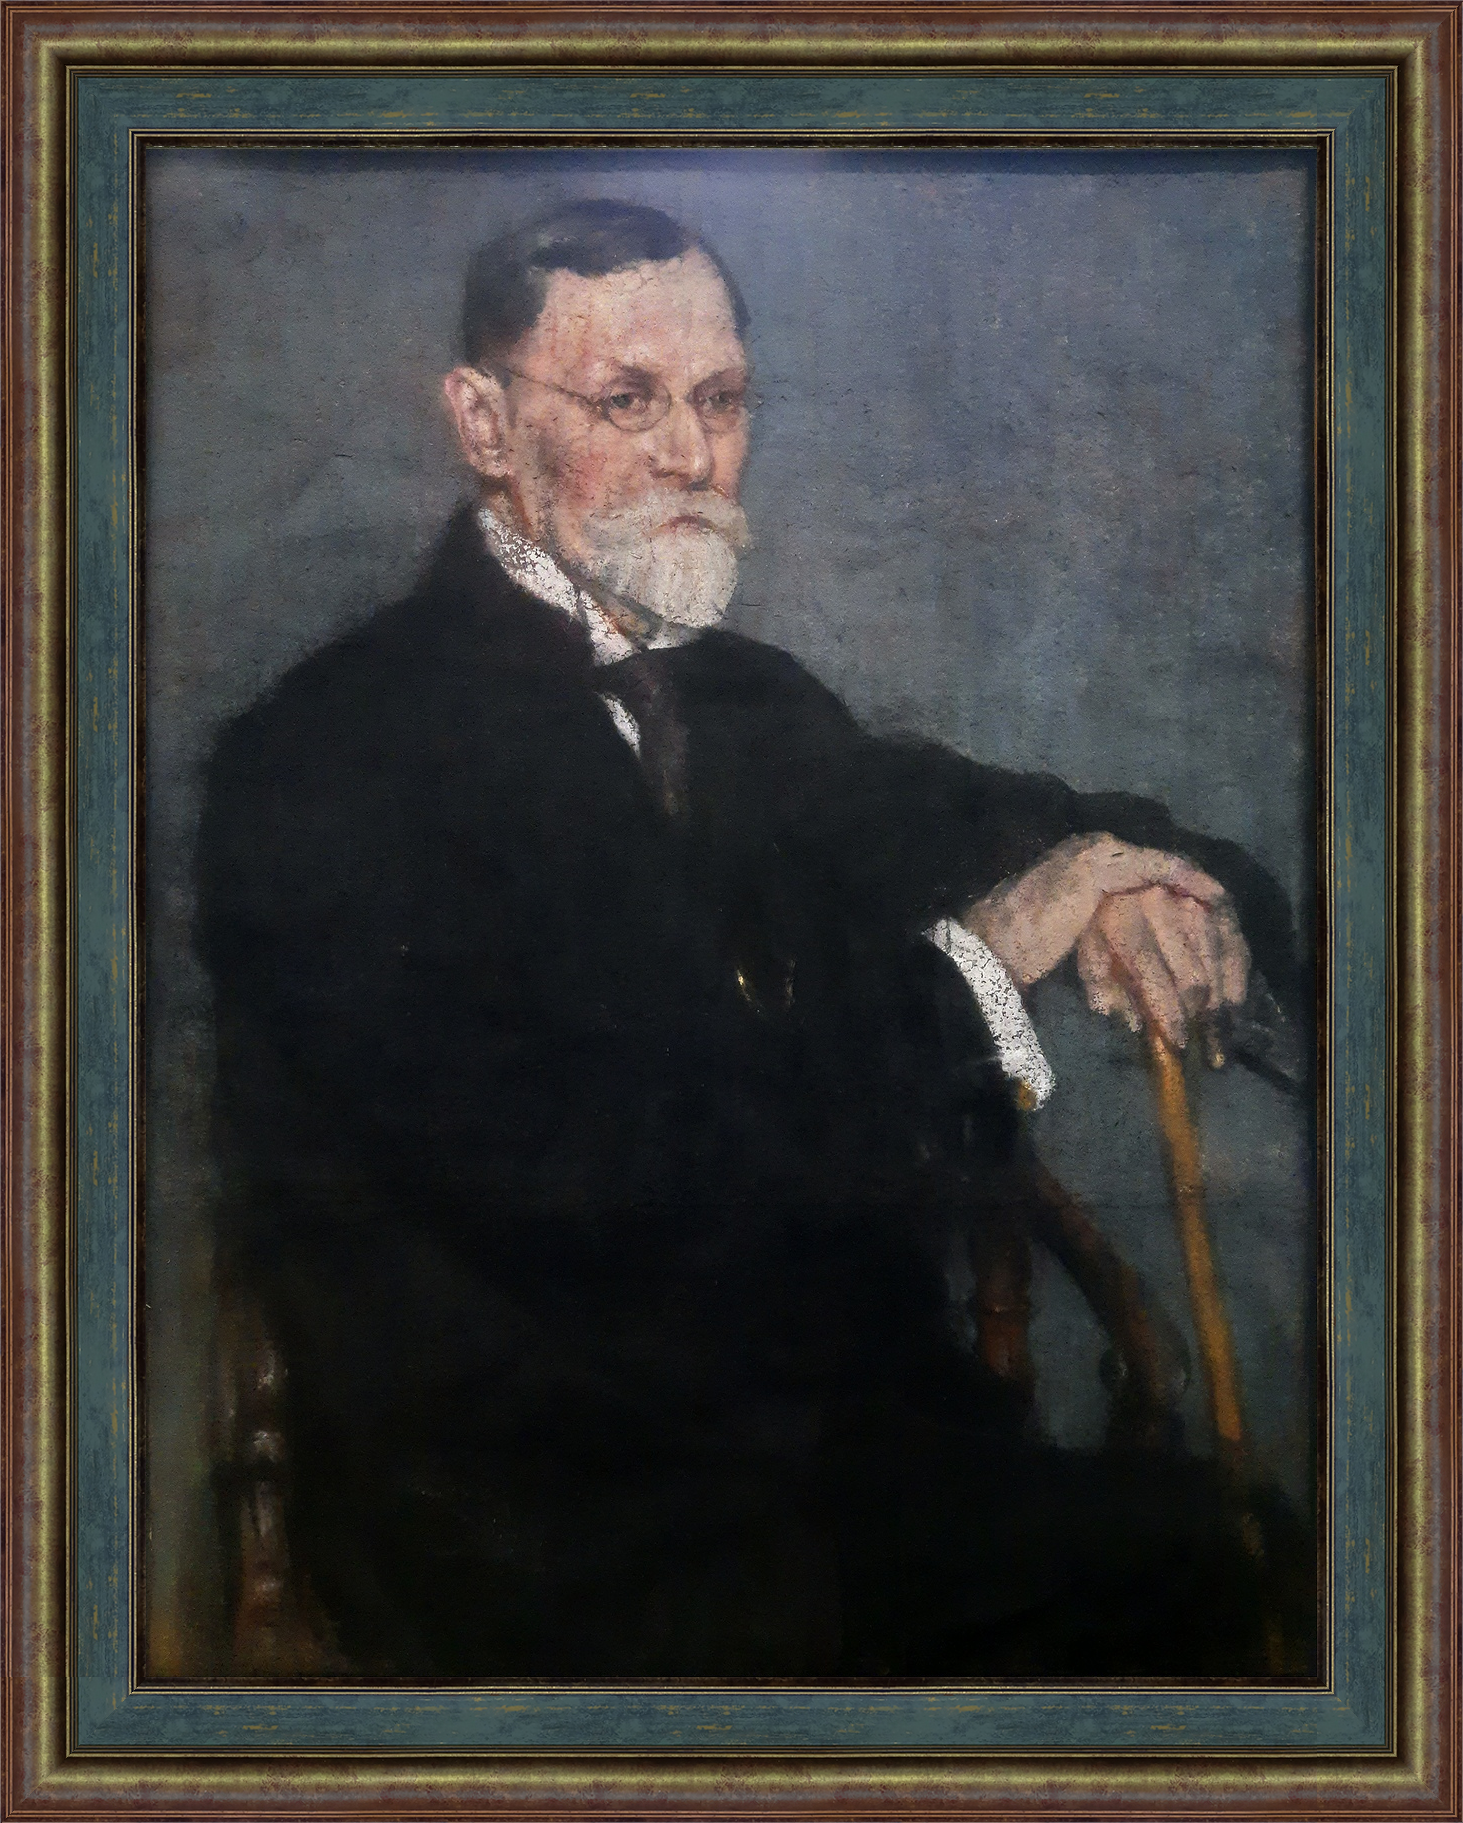

In [12]:
add_baguette(painting_sample, baguette_sample, sample_image_height_mm, sample_baguette_height_mm)

In [13]:
import re

baguette_name_format = re.compile('.*-(\d+)\.\w+')

def deduce_baguette_width(filename: str):
    try:
        return int(baguette_name_format.match(filename).group(1))
    except:
        return None

Dropdown(description='Painting:', options=('0.png',), value='0.png')

IntText(value=970, description='Painting height (mm):')

Dropdown(description='Baguette:', options=('0.jpg', '10003 MT 2.0-4.jpg', '112 OAK 115 97052-96.jpg', '18.5334…

IntText(value=93, description='Baguette width (mm):')

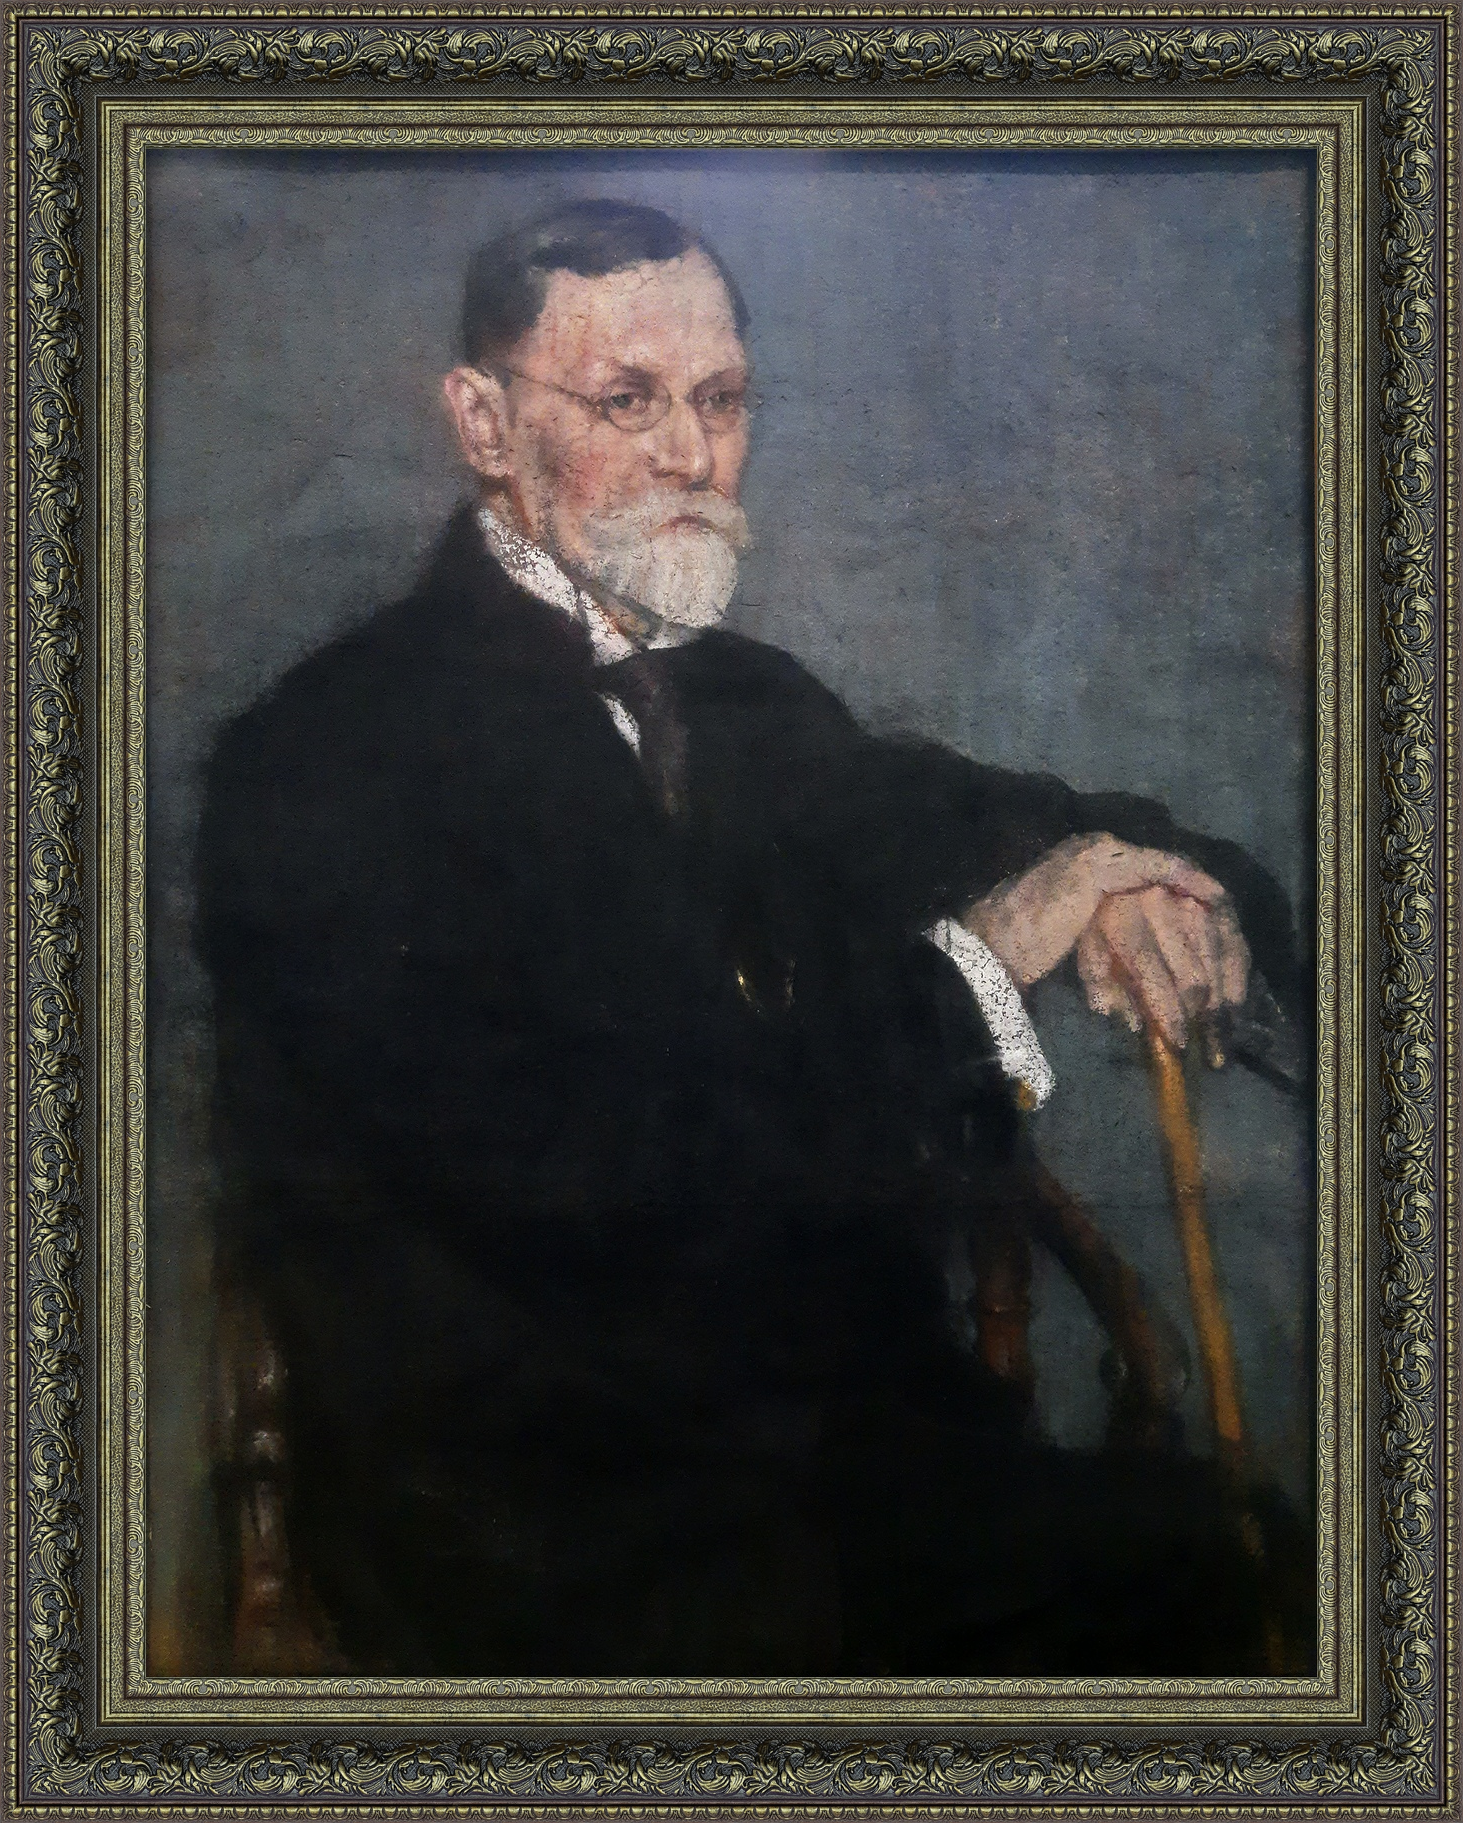

In [14]:
from os import listdir
from os.path import isfile, join
from IPython.display import display, clear_output

baguette_image_name = '0.jpg'
baguette_width = 93
painting_image_name = '0.png'
painting_height = 970

def get_files(directory):
    return [f for f in listdir(directory) if isfile(join(directory, f))]


baguette_image_widget = widgets.Dropdown(
    options=get_files('baguettes'),
    description='Baguette:',
    value=baguette_image_name,
    disabled=False,
)

baguette_image_width_widget = widgets.IntText(
   value=baguette_width,
   description='Baguette width (mm):',
   disabled=False
)

painting_image_widget = widgets.Dropdown(
    options=get_files('paintings'),
    description='Painting:',
    value=painting_image_name,
    disabled=False,
)

painting_image_height_widget = widgets.IntText(
   value=painting_height,
   description='Painting height (mm):',
   disabled=False
)

def update():
    clear_output()
    display(painting_image_widget)
    display(painting_image_height_widget)
    display(baguette_image_widget)
    display(baguette_image_width_widget)

    baguette_image = Image.open('baguettes/' + baguette_image_name, 'r')
    painting_image = Image.open('paintings/' + painting_image_name, 'r')

    display(add_baguette(painting_image, baguette_image, painting_height, baguette_width))

def baguette_selection_handler(event):
    global baguette_image_name
    global baguette_width

    if event.name == 'value':
        print('Selected baguette: ' + str(event.new))
        baguette_image_name = event.new

        height = deduce_baguette_width(baguette_image_name)
        if height:
            baguette_width = height
            baguette_image_width_widget.value = baguette_width

        update()

def painting_selection_handler(event):
    global painting_image_name
    if event.name == 'value':
        print('Selected painting: ' + str(event.new))
        painting_image_name = event.new
        update()

def painting_image_height_handler(event):
    global painting_height
    if event.name == 'value':
        print('Painting height: ' + str(event.new))
        painting_height = event.new
        update()

def baguette_image_width_handler(event):
    global baguette_width
    if event.name == 'value':
        print('Baguette width: ' + str(event.new))
        baguette_width = event.new
        update()
    
update()
painting_image_widget.observe(painting_selection_handler)
painting_image_height_widget.observe(painting_image_height_handler)
baguette_image_widget.observe(baguette_selection_handler)
baguette_image_width_widget.observe(baguette_image_width_handler)